# Objectifs

- Lire les résultats des tests sur les 4 fichiers pour les corpus d'entraînement de D Longrée.
- Ajouter le nombre de tokens par corpus en lisant le fichier CSV lié ?

## Étape 1 : Lecture des résultats

In [1]:
import glob
import os.path
import re
from collections import defaultdict

re_sub = re.compile(r"^([\w-]+):$")
re_metric = re.compile(r"^([\w-]+): ([\d\.]+)$")
re_model_name = re.compile(
    r"model-1\.4\.5-lemma-\d{4}_\d{2}_\d{2}-\d{2}_\d{2}_\d{2}\.d-([a-zA-Z\-\+\_]+)_-_([A-Za-z0-9_]+)_-_"
)

def get_model_name(model_name):
    model, test = re_model_name.findall(model_name)[0]
    layers = "2"
    if "light" in model:
        layers = "1"
        model = model.replace("-light", "")
    model = " ".join([x for x in model.split("-") if x]).capitalize()
    return model, test, layers

#results = {
    #models : {
    #  {test-file: {metric: score}}
    #}
#}

results = defaultdict( # Key: Task
    lambda: defaultdict( # Key : model
        lambda: defaultdict( # Key : layers
            lambda: defaultdict( # Key : Test
                lambda: defaultdict( # Key Subtask
                    lambda: defaultdict( # Key Metric
                        str
                    )
                )
            )
        )
    )
)


header = [["model", "layers"]]
tests = []
metrics = []
models = []
tasks = defaultdict(list)

for file in glob.glob("./results/1.4.5.d/Tests/*.txt"):
    basename = os.path.basename(file)
    model, test, layers = get_model_name(file)
    if (model, layers) not in models:
        models.append((model, layers))
    
    if test not in tests:
        tests.append(test)
        
    with open(file) as f:
        task, subtask = None, None
        for line in f:
            line = line.strip()
            if line.startswith("::: Evaluation report for task: "):
                task = line[len("::: Evaluation report for task: "): -4]
                continue
                
            if re_sub.match(line):
                subtask = re_sub.findall(line)[0]
                continue
                
            if re_metric.match(line):
                metric, number = re_metric.findall(line)[0]
                if (subtask, metric) not in tasks[task]:
                    tasks[task].append((subtask, metric))
                results[task][model][layers][test][subtask][metric] = number

## Étape 2: Enrichissement 

Ajout nombre de tokens

In [2]:
# Liste auto
re_model_name = re.compile("Data/([\w\-\+]+)-(?:train|dev)")
training_corpora = set()

for file in glob.glob("./results/1.4.5.d/Data/*.tsv"):
    training_corpora.add(re_model_name.findall(file)[0])
    
from pprint import pprint

pprint({m_name: "" for m_name, _ in models})
pprint(sorted(list(training_corpora)))

{'Cicero discours': '',
 'Ciceron petit': '',
 'Corpus divers': '',
 'Horace_lucrece': '',
 'Ovide': '',
 'Prose': '',
 'Seneque lucilium': '',
 'Seneque philo autres': '',
 'Tacite': '',
 'Theatre plaute seneque': '',
 'Vers': '',
 'Virgile': ''}
['cicero-discours',
 'ciceron-petit',
 'corpus-divers',
 'horace+lucrece',
 'ovide',
 'prose',
 'seneque-lucilium',
 'seneque-philo-autres',
 'tacite',
 'theatre-plaute-seneque',
 'vers',
 'virgile']


In [3]:
training_files = {
    'Cicero discours': 'cicero-discours',
    'Ciceron petit': 'ciceron-petit',
    'Corpus divers': 'corpus-divers',
    'Horace_lucrece': 'horace+lucrece',
    'Ovide': 'ovide',
    'Prose': 'prose',
    'Seneque lucilium': 'seneque-lucilium',
    'Seneque philo autres': 'seneque-philo-autres',
    'Tacite': 'tacite',
    'Theatre plaute seneque': 'theatre-plaute-seneque',
    'Vers': 'vers',
    'Virgile': 'virgile'
}

def get_token(file, extension):
    toks = -1  # Remove -1 for the header
    with open("./results/1.4.5.d/Data/{}-{}.tsv".format(file, extension)) as f:
        for line in f:
            if line.strip():
                toks += 1
    return toks

tokens_per_corpus = {
    corpus_name: (
        get_token(training_file, "train"),
        get_token(training_file, "dev")
    )
    for corpus_name, training_file in training_files.items()
}

## Étape 3: Export

In [4]:
import csv
for task, metrics in tasks.items():
    header = [
        "model", "layers", "train_tokens", "dev_tokens", "test"] + [
        "{} / {}".format(" ".join(t.split("-")).capitalize(), m.capitalize()) for t, m in metrics
    ]
    rows = [header]
    for test in sorted(tests):
        for model, layer in sorted(models, key=lambda x: x[0]+x[1]):
            row = [model, layer, tokens_per_corpus[model][0], tokens_per_corpus[model][1], test]
            for subtask, metric in metrics:
                row.append(results[task][model][layer][test][subtask][metric])
            rows.append(row)
    with open("results/1.4.5.d/table-"+task+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(rows)

## Étape 4 : Curation manuelle

Préparation des graphiques: création de label plus agréables

In [5]:
nice_tests = {'Caesar_BellumGallicum_CaesBG3': 'Cesar, Guerre des Gaules, 3',
             'Catullus_Catullus_Catul': 'Catulle',
             'Cicero_DeAmicitia_CicAmici': 'Cicéron, De l\'amitié',
             'Cicero_InCatilinam_CicCat1': 'Cicéron, Catilinaires, 1',
             'Curtius_CurtiusHistoriaeAlexandriMagni_QCurt03': 'Quinte-Curce, Histoires, 3',
             'Horatius_Epodi_HorEpodi': 'Horace, Epodes',
             'Ovidius_InIbin_OviIbin': 'Ovide, Ibis',
             'Petronius_PetroniusSatiricon_PetronSa': 'Pétrone, Satyricon',
             'PseudoCaesar1_BellumAfricanum_BAfr': 'Pseudo-César, Guerre d\'Afrique',
             'Sallustius_Catilina_SalCatil': 'Salluste, Catilinaires',
             'Seneca_DeBrevitateVitae_SenBrevi': 'Sénèque, De la brièveté de la vie',
             'Seneca_Medea_SenMedea': 'Sénéque, Médée',
             'Tacitus_TacGermania_TacGerma': 'Tacite, Germaniques',
             'Vergilius_Eclogae_VergEclo': 'Virgile, Eclogues'}

nice_train = {'Cicero discours': 'Ciceron (Discours)',
 'Ciceron petit': 'Ciceron (Petit)',
 'Corpus divers': 'Corpus Divers',
 'Horace_lucrece': 'Horace & Lucrece',
 'Ovide': 'Ovide',
 'Prose': 'Prose',
 'Seneque lucilium': 'Seneque (Lucilium)',
 'Seneque philo autres': 'Seneque (Philosophie)',
 'Tacite': 'Tacite',
 'Theatre plaute seneque': 'Seneque & Plaute (Theatre)',
 'Vers': 'Vers',
 'Virgile': 'Virgile'
}

analyzed_groups = {
    "Style de Poésie": (
        ['Horace_lucrece', 'Ovide', 'Virgile'],
        [
            # Autres auteurs dont 2 prose
           'Caesar_BellumGallicum_CaesBG3',
           'Catullus_Catullus_Catul', 
           'Petronius_PetroniusSatiricon_PetronSa',
           'Seneca_Medea_SenMedea',
            # Memes auteurs
           'Horatius_Epodi_HorEpodi',
           'Ovidius_InIbin_OviIbin',
           'Vergilius_Eclogae_VergEclo'
        ]
    ),
    "Style d'auteur, style de genre": 
        ([
            'Theatre plaute seneque',
            'Seneque lucilium',
            'Seneque philo autres',
            'Tacite',
            'Ciceron petit'
        ], [
            # Autres auteurs
            'Catullus_Catullus_Catul',
            'Petronius_PetroniusSatiricon_PetronSa',
            'Sallustius_Catilina_SalCatil',
            # Memes auteurs
            'Seneca_DeBrevitateVitae_SenBrevi',
            'Seneca_Medea_SenMedea',
            'Cicero_DeAmicitia_CicAmici',
            'Cicero_InCatilinam_CicCat1',
            'Tacitus_TacGermania_TacGerma'
        ]),
    "Mode d'expression": ([
        "Vers", "Prose"
    ], [
        'Caesar_BellumGallicum_CaesBG3',
        'PseudoCaesar1_BellumAfricanum_BAfr',
        'Cicero_DeAmicitia_CicAmici',
        'Cicero_InCatilinam_CicCat1',
        'Curtius_CurtiusHistoriaeAlexandriMagni_QCurt03',
        'Sallustius_Catilina_SalCatil',
        'Seneca_DeBrevitateVitae_SenBrevi',
        'Tacitus_TacGermania_TacGerma',
        # Mixte
        'Petronius_PetroniusSatiricon_PetronSa',
        # Vers
        'Horatius_Epodi_HorEpodi',
        'Ovidius_InIbin_OviIbin',
        'Catullus_Catullus_Catul',
        'Vergilius_Eclogae_VergEclo',
        # Theatre
        'Seneca_Medea_SenMedea'
    ]),
    "Diversité d'auteurs contre diversité d'auteur'" : ([
        "Cicero discours",
        "Corpus divers"
    ], [
        'Caesar_BellumGallicum_CaesBG3',
        'PseudoCaesar1_BellumAfricanum_BAfr',
        'Cicero_DeAmicitia_CicAmici',
        'Cicero_InCatilinam_CicCat1',
        'Curtius_CurtiusHistoriaeAlexandriMagni_QCurt03',
        'Sallustius_Catilina_SalCatil',
        'Seneca_DeBrevitateVitae_SenBrevi',
        'Tacitus_TacGermania_TacGerma',
        # Mixte
        'Petronius_PetroniusSatiricon_PetronSa',
        # Vers
        'Horatius_Epodi_HorEpodi',
        'Ovidius_InIbin_OviIbin',
        'Catullus_Catullus_Catul',
        'Vergilius_Eclogae_VergEclo',
        # Theatre
        'Seneca_Medea_SenMedea'
    ])
}

nb_test_tokens = {
    
}

In [6]:
for file in nice_tests:
    toks = -1  # Remove -1 for the header
    with open("./results/1.4.5.d/Data/tests/{}.tsv".format(file)) as f:
        for line in f:
            if line.strip():
                toks += 1
    nb_test_tokens[file] = toks

print(nb_test_tokens)

{'Caesar_BellumGallicum_CaesBG3': 3403, 'Catullus_Catullus_Catul': 12397, 'Cicero_DeAmicitia_CicAmici': 8735, 'Cicero_InCatilinam_CicCat1': 3095, 'Curtius_CurtiusHistoriaeAlexandriMagni_QCurt03': 6776, 'Horatius_Epodi_HorEpodi': 2896, 'Ovidius_InIbin_OviIbin': 4007, 'Petronius_PetroniusSatiricon_PetronSa': 29114, 'PseudoCaesar1_BellumAfricanum_BAfr': 12634, 'Sallustius_Catilina_SalCatil': 10020, 'Seneca_DeBrevitateVitae_SenBrevi': 5883, 'Seneca_Medea_SenMedea': 5464, 'Tacitus_TacGermania_TacGerma': 5333, 'Vergilius_Eclogae_VergEclo': 5424}


## Étape 5 : Curation manuelle

## Étape 6: DataFrame


In [7]:
import pandas

df_l = pandas.read_csv("results/1.4.5.d/table-lemma.csv")
df_p = pandas.read_csv("results/1.4.5.d/table-pos.csv")
df_g = pandas.read_csv("results/1.4.5.d/table-Gend.csv")

## Étape 7: Étude impact Light Vs Heavy

In [8]:
l_1 = df_l[(df_l["layers"]==1)]
l_2 = df_l[(df_l["layers"]==2)]
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure()
axes = plt.axes()
fig.set_size_inches(7.5, 3.5, forward=True)
fig.set_dpi(300)
fig.patch.set_facecolor('xkcd:white')

l_1 = l_1.sort_values("train_tokens")
l_2 = l_2.sort_values("train_tokens")

acc_all = pd.Series(list(l_2["All / Accuracy"])) - pd.Series(list(l_1["All / Accuracy"]))
prec_all = pd.Series(list(l_2["All / Precision"])) - pd.Series(list(l_1["All / Precision"]))
acc_tok = pd.Series(list(l_2["Unknown tokens / Accuracy"])) - pd.Series(list(l_1["Unknown tokens / Accuracy"]))
prec_tok = pd.Series(list(l_2["Unknown tokens / Precision"])) - pd.Series(list(l_1["Unknown tokens / Precision"]))
acc_tar = pd.Series(list(l_2["Unknown targets / Accuracy"])) - pd.Series(list(l_1["Unknown targets / Accuracy"]))
prec_tar = pd.Series(list(l_2["Unknown targets / Precision"])) - pd.Series(list(l_1["Unknown targets / Precision"]))

axes.boxplot(
    [acc_all, acc_tok, acc_tar, prec_all, prec_tok, prec_tar], notch=True
)
axes.set_xticklabels(
    ["Accuracy (All)", "Accuracy \n(Unknown Tokens)", "Accuracy \n(Unknown Targets)",
     "Precision (All)", "Precision \n(Unknown Tokens)", "Precision \n(Unknown Targets)"],
    rotation=-45
)
axes.axhline(y=0, linewidth=1, color="gray")
axes.set_title("Difference between light models and heavy models, on a wide range of tests and training corpora \n(Model Score - Light Model Score)")

Text(0.5,1,'Difference between light models and heavy models, on a wide range of tests and training corpora \n(Model Score - Light Model Score)')

## Étape 6 : Étude par sous-groupe

On ne conserve que le layer 2

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/ipykernel_launcher.py:68: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement


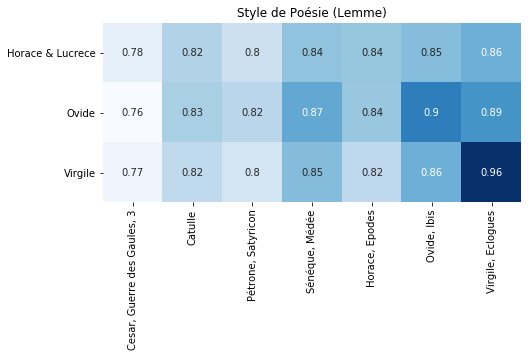

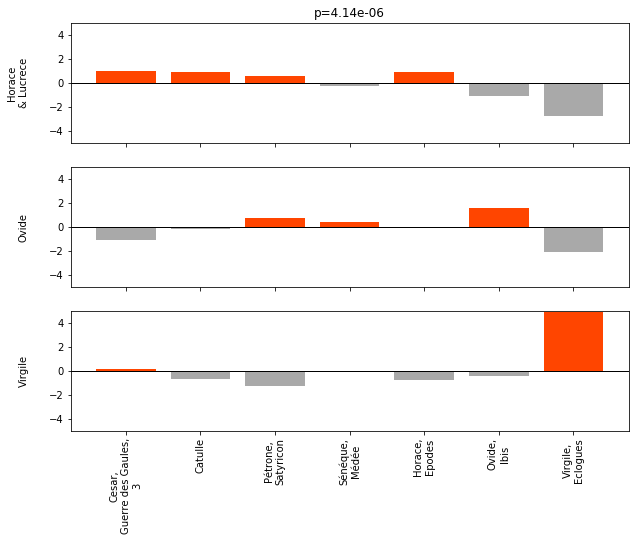

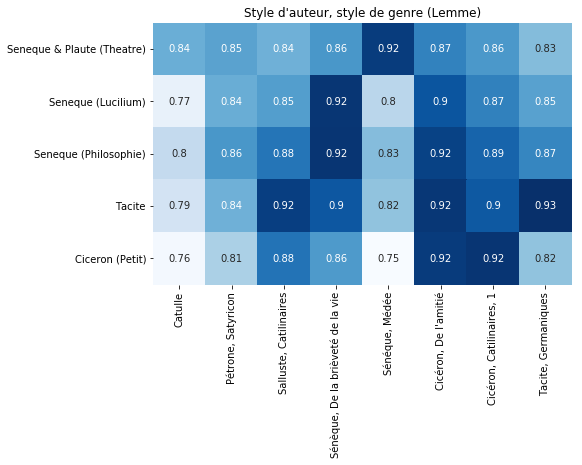

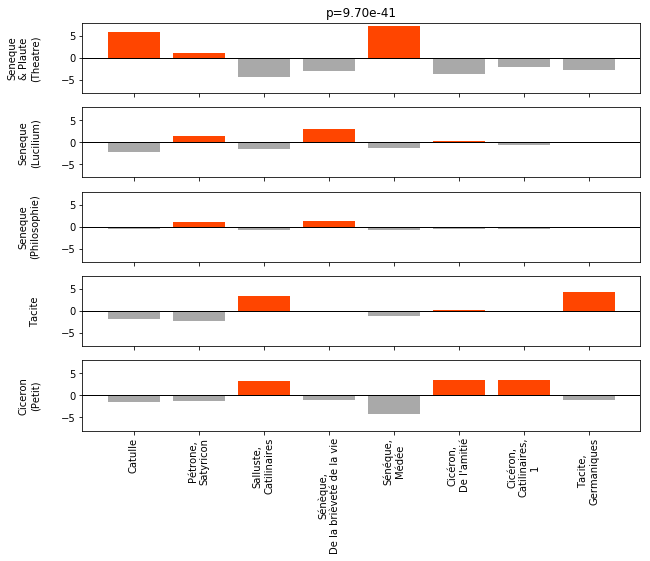

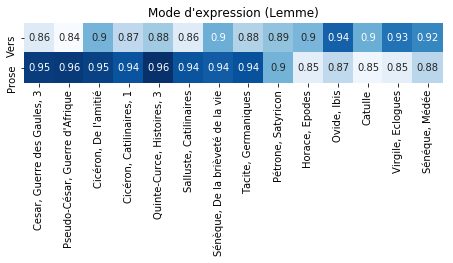

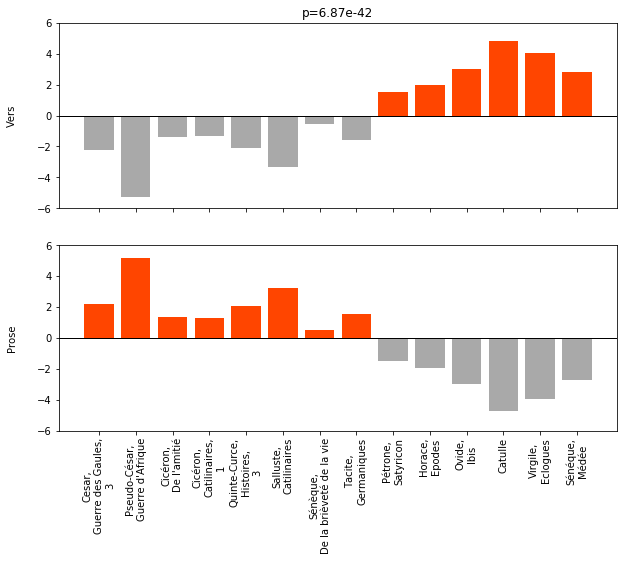

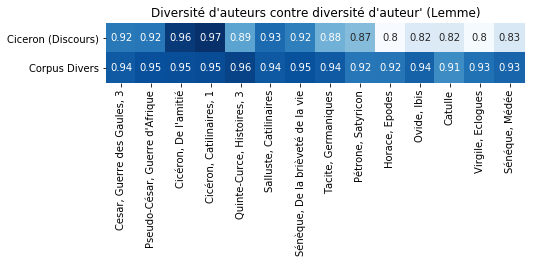

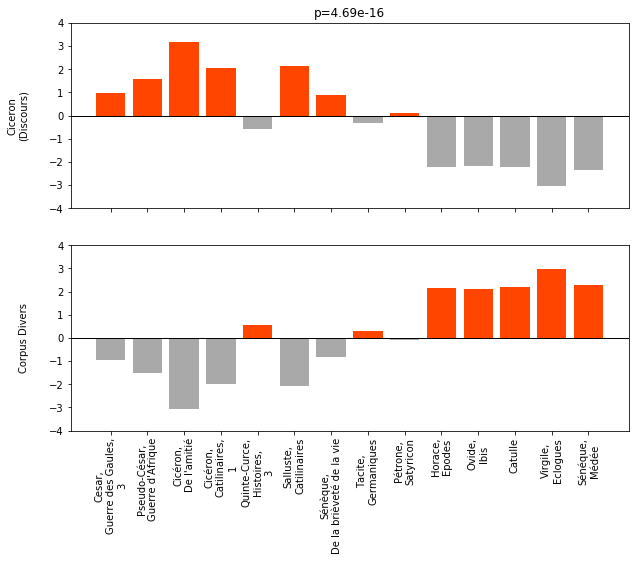

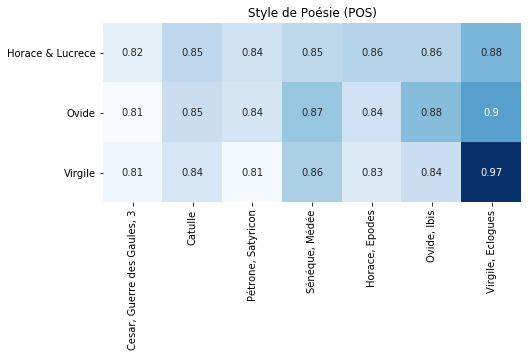

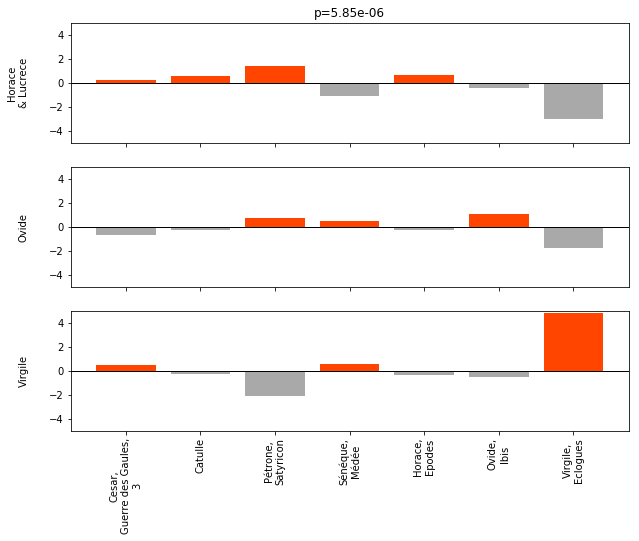

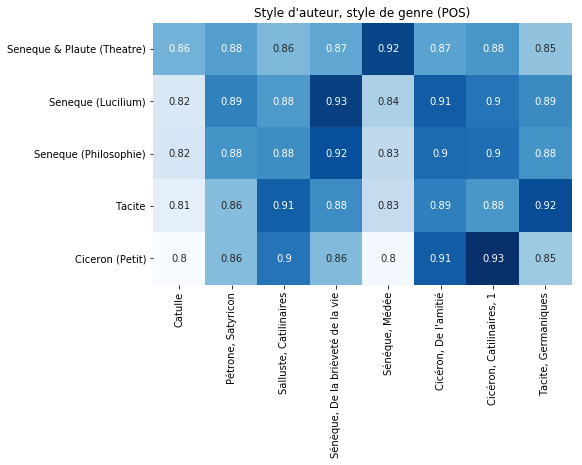

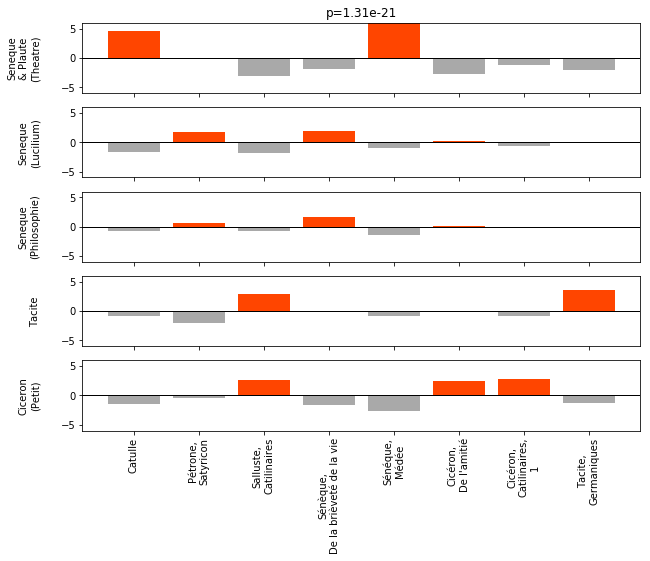

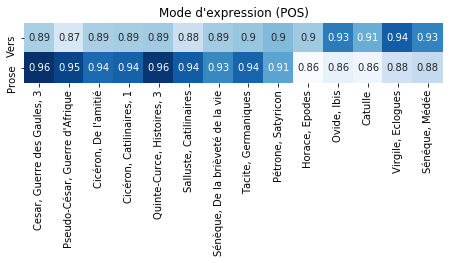

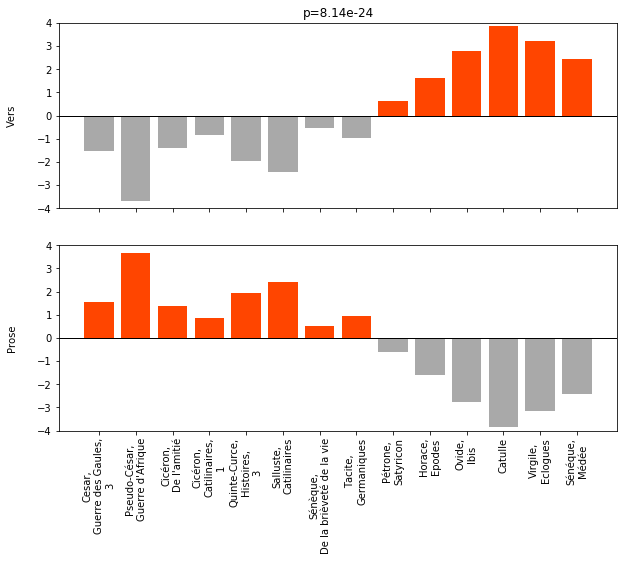

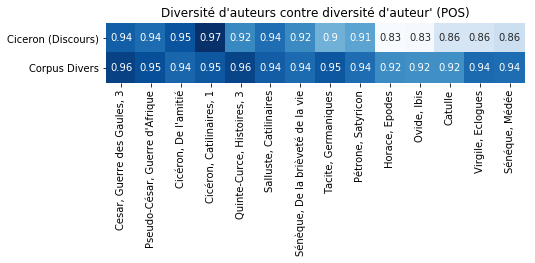

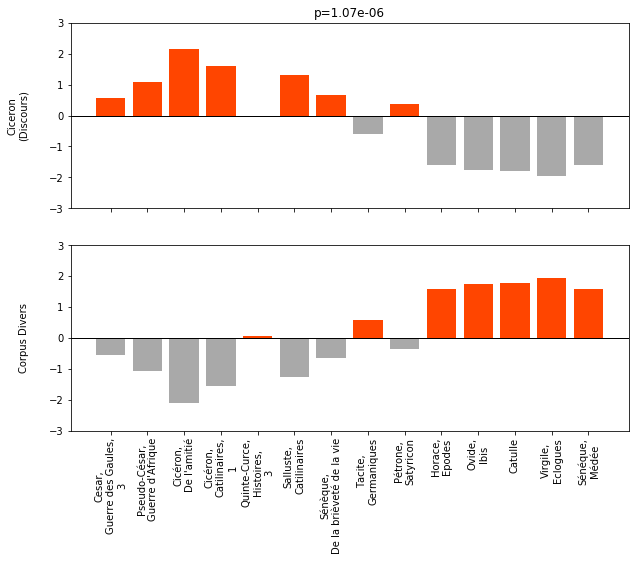

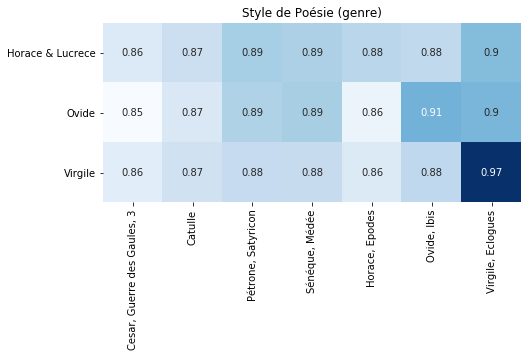

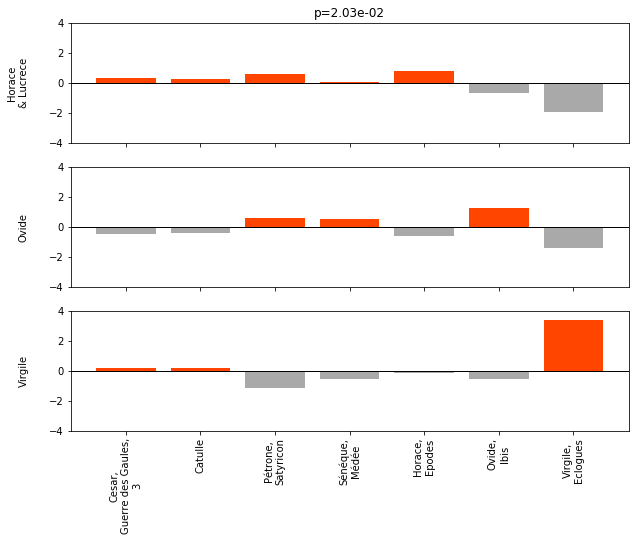

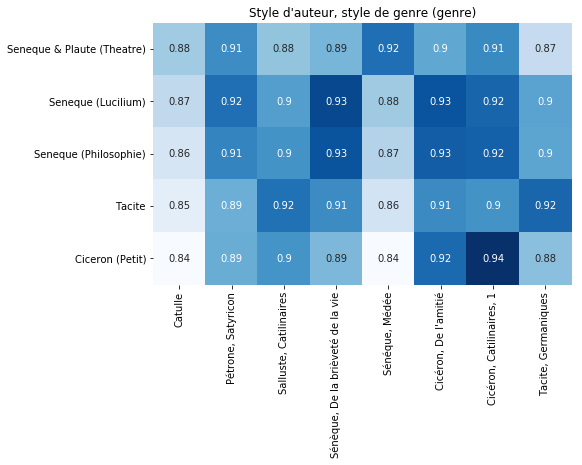

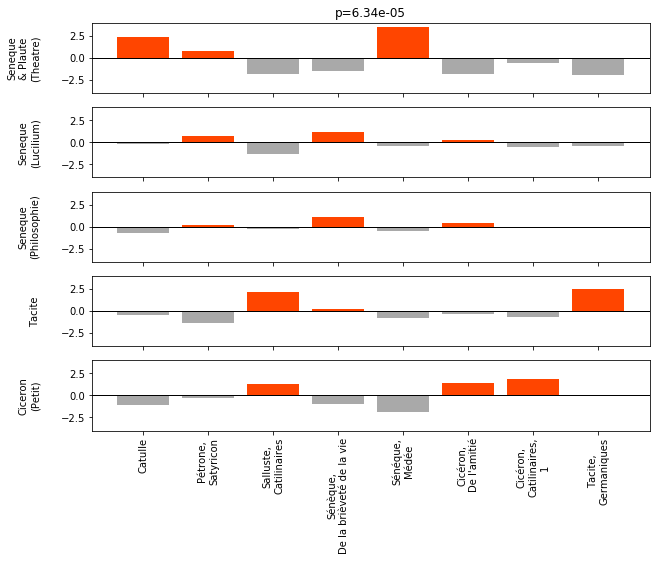

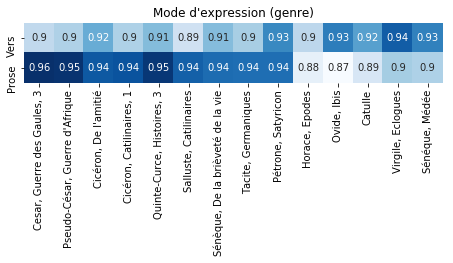

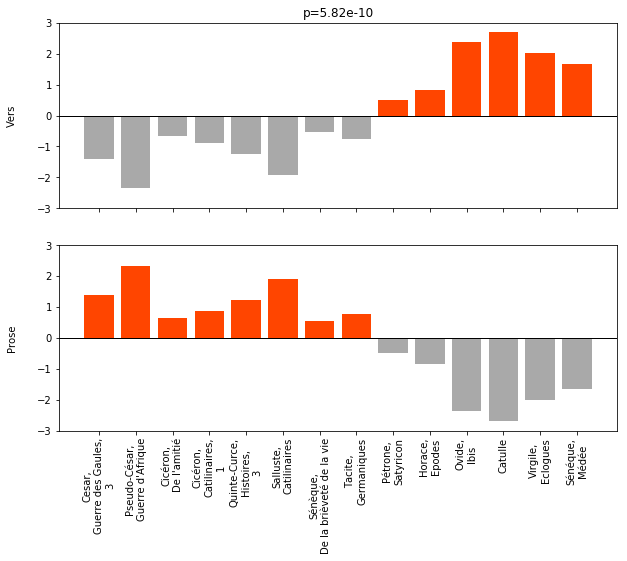

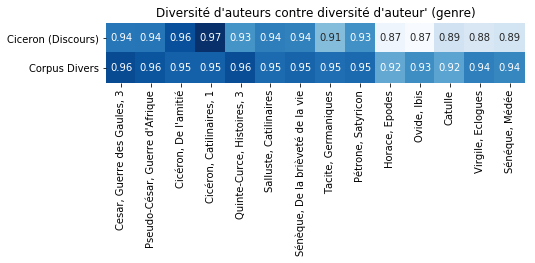

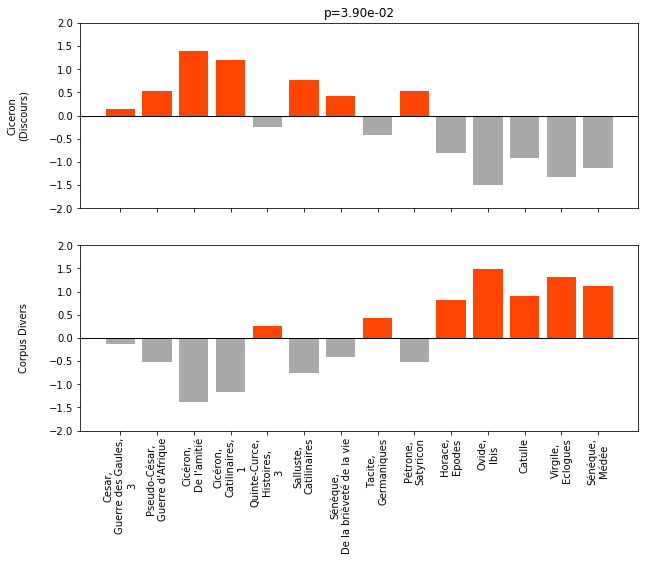

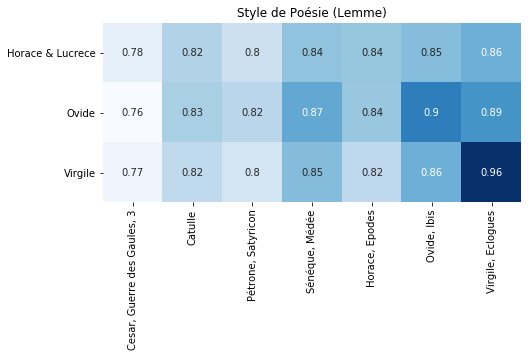

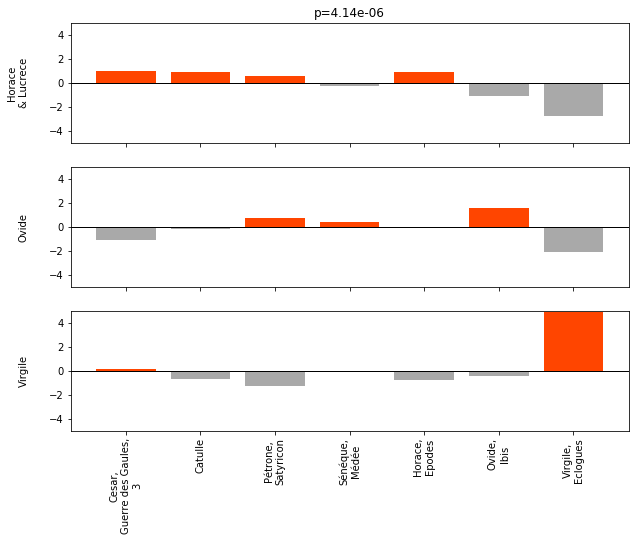

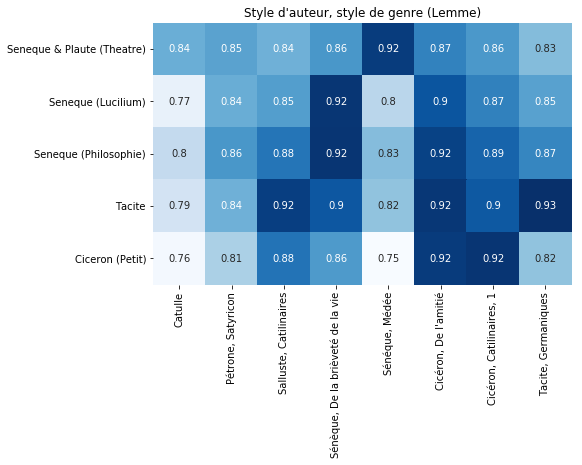

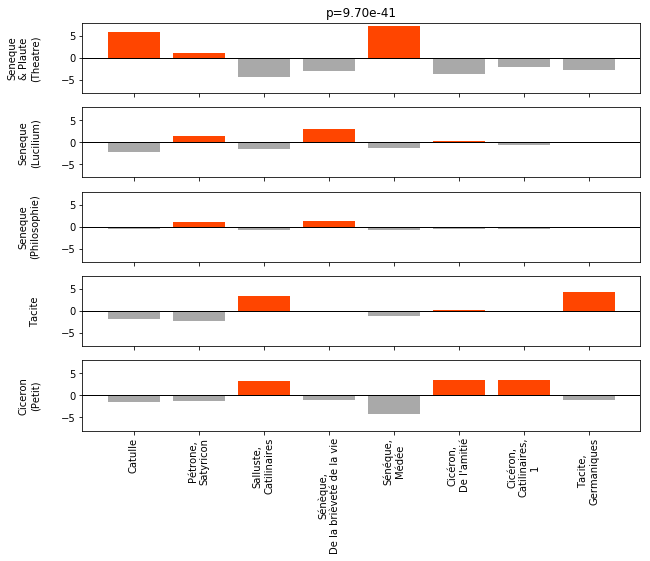

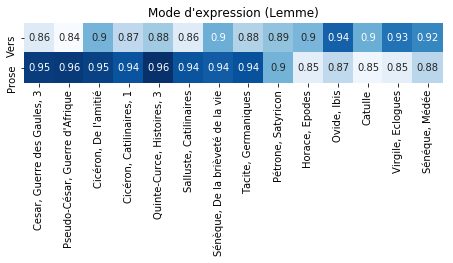

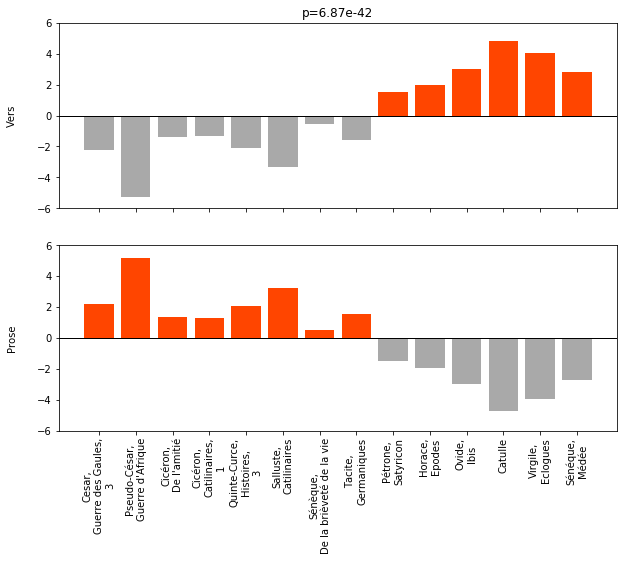

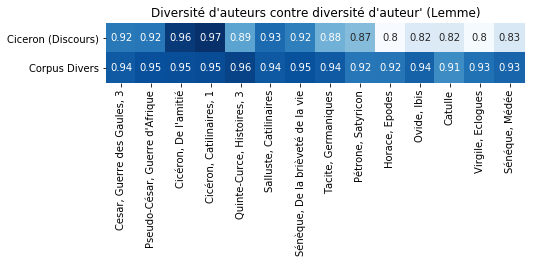

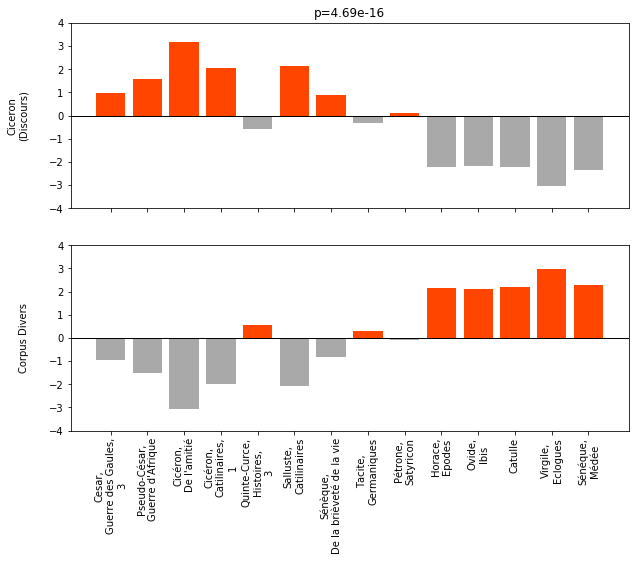

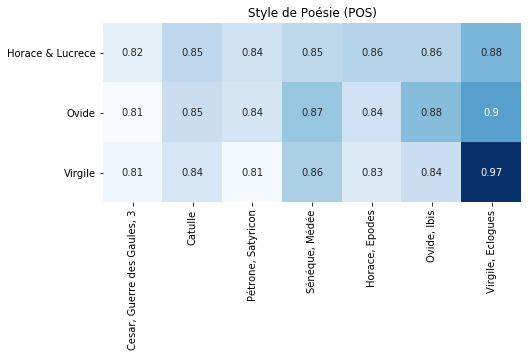

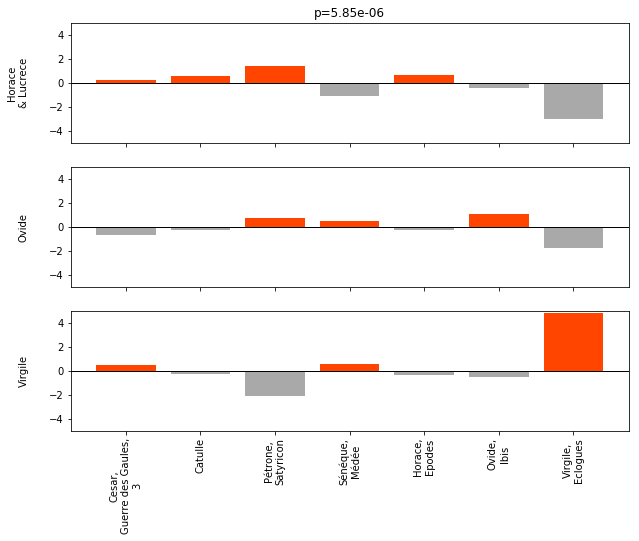

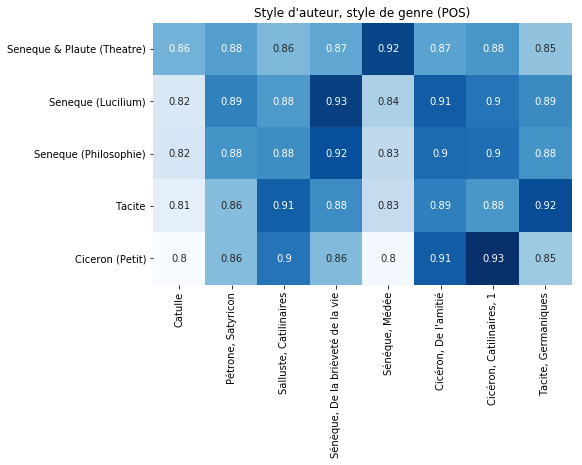

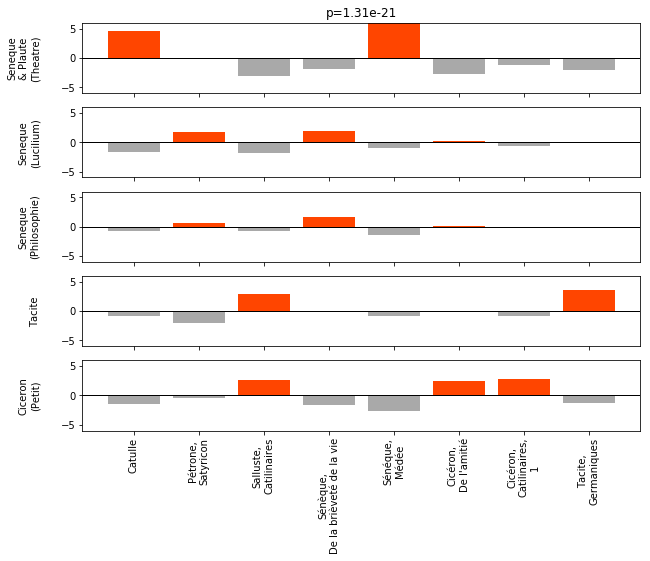

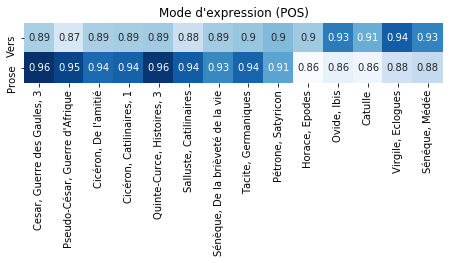

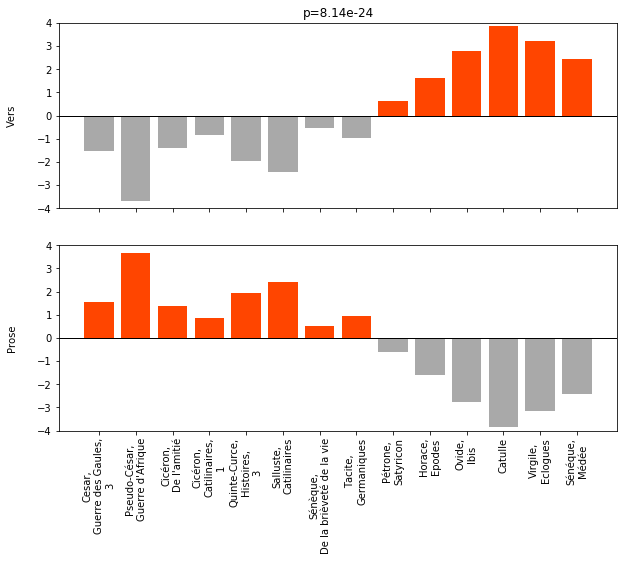

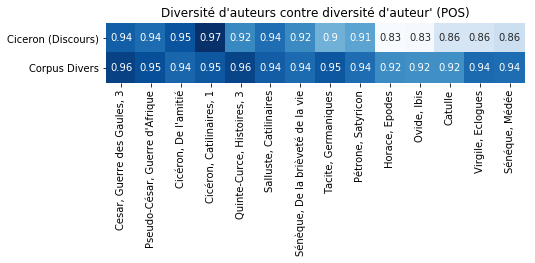

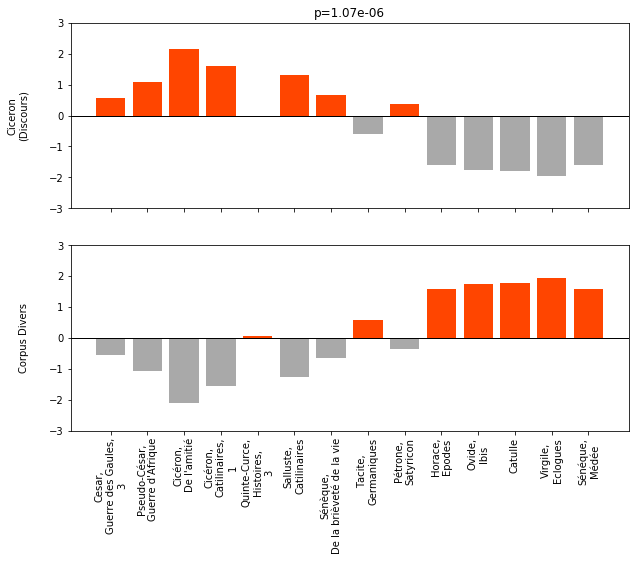

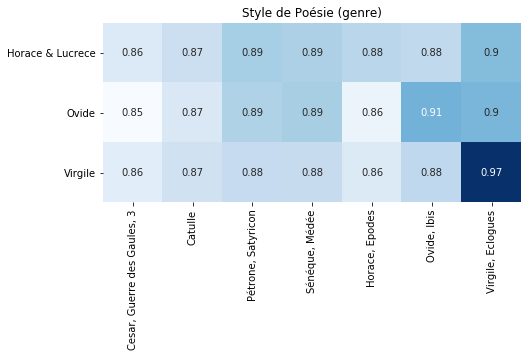

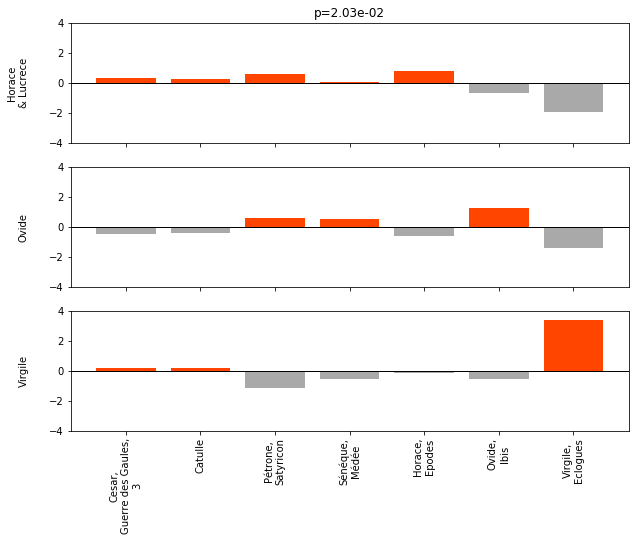

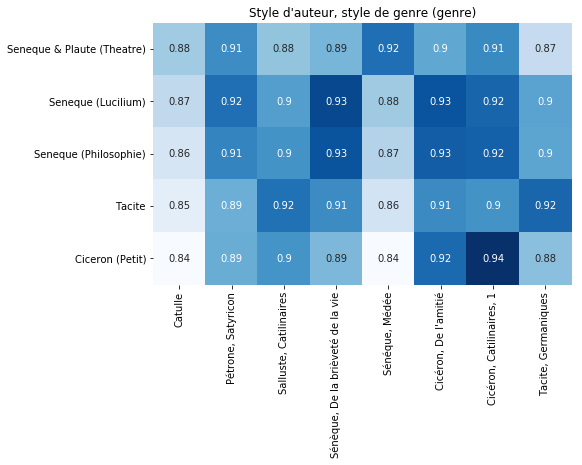

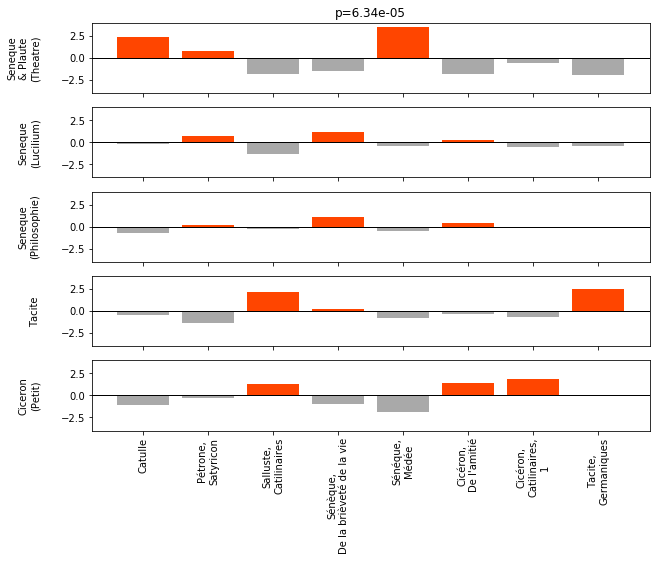

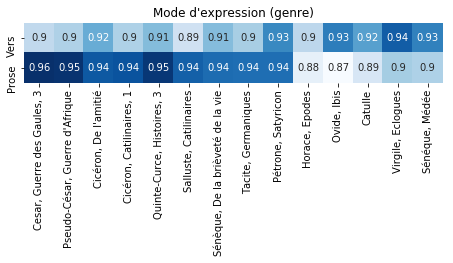

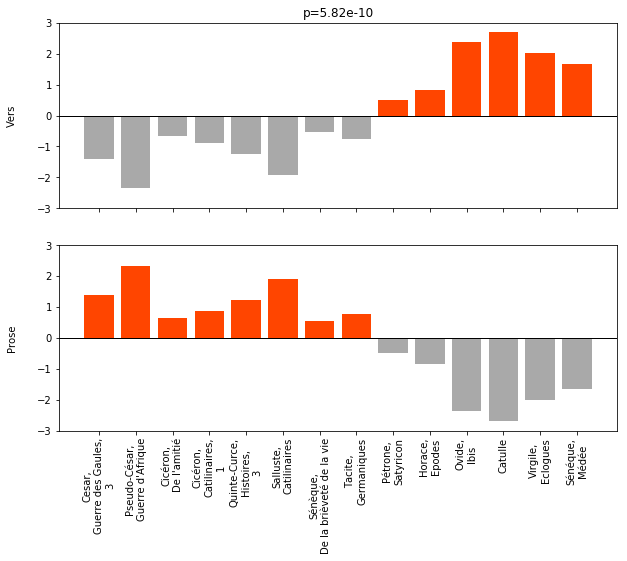

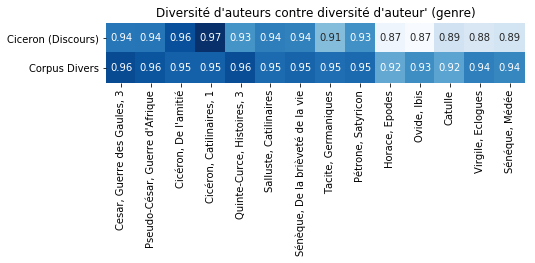

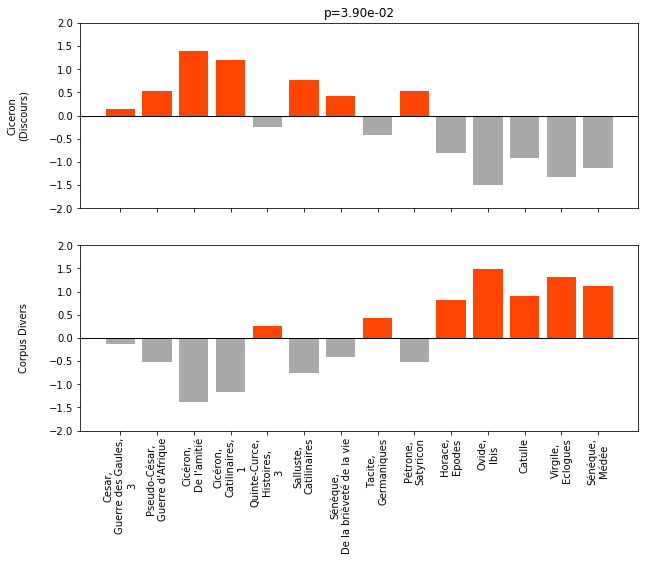

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, chi2, chisquare
import numpy as np
import math
from IPython.display import display
%matplotlib inline

success_color, failure_color = "orangered", "darkgray"

def choose_color(value):
    if value < 0:
        return failure_color
    return success_color

def create_assoc_plot(df, train_nice_names, test_nice_names, toks, p):
    nb_subplot = len(df.index)
    
    # Set up the matplotlib figure
    f, axes = plt.subplots(nb_subplot, 1, figsize=(7, 7), sharex=True)
    
    f.set_size_inches(10, 7.5, forward=True)
    #fig.set_dpi(300)
    f.patch.set_facecolor('xkcd:white')
    
    x = [test_nice_names[acc].replace(", ", ",\n") for acc in df.columns]
    max_y, min_y = math.ceil(df.max().max()), math.floor(df.min().min())
    min_max = max([abs(max_y), abs(min_y)])
        
    for ax, index in zip(axes, df.index):
        value_list = df.loc[index].tolist()
        ax.bar(
            x=list(range(1, len(value_list)+1)),
            height=value_list, 
            color=[choose_color(y) for y in value_list]
        )
        
        ax.axhline(0, color="k", clip_on=True, linewidth=1)
        
        ax.set_ylabel(
            train_nice_names.get(index, None).replace(" (","\n(").replace(" & ", "\n& "), 
            rotation="vertical", labelpad=20)
        
        ax.set_ylim(-min_max, min_max)
    
    ax.set_xticks(list(range(1, len(x)+1)))
    ax.set_xticklabels(x, rotation=90)
        
    axes[0].set_title("p={:.2e}".format(p))
    return f


def get_filtered(df, models, tests, token_per_corpus, selected_metric="All / Accuracy"):
    """
    
    :param models: List of indexes to show in the results (models)
    :param tests: List of columns to keep in the results (tests)
    :param selected_metric]: Metric to evaluate
    
    """
    lemma = df[(df["layers"]==2)]
    
    # Pour la heatmap, on réorganise les tests en colonne, les modèles en row.
    df_metric = lemma.pivot(index="model", columns="test", values=[selected_metric])
    # On limite aux tests sélectionnés
    df_metric = df_metric.loc[models]
    df_metric = df_metric.select(lambda x: x[1] in tests, axis=1)
    df_metric = df_metric[selected_metric].loc[:, tests]
    
    # On calcule désormais les khi
    aligned_tokens_count = np.array([token_per_corpus[acc] for acc in df_metric.columns])
    df_population = (df_metric * aligned_tokens_count).astype(int)
    _, p, dof, df_expected = chi2_contingency(df_population)
    df_residus = (df_population - df_expected) / np.sqrt(df_expected)
    return df_metric, (p, df_residus), aligned_tokens_count

for task, df in [("Lemme", df_l), ("POS", df_p), ("genre", df_g)]:
    for title, (group, ordered_tests) in analyzed_groups.items():
        df_metric, (p, df_residus), aligned_tokens_count = get_filtered(
            df=df,
            models=group, tests=ordered_tests,
            token_per_corpus=nb_test_tokens
        )

        # Draw the heat map
        fig = plt.figure()
        axes = plt.axes()
        fig.set_size_inches(7.5, 7.5, forward=True)
        #fig.set_dpi(300)
        fig.patch.set_facecolor('xkcd:white')
        axes.set_title("{} ({})".format(title, task))
        sns.heatmap(
            df_metric,
            ax=axes, annot=True, square=True, 
            cmap="Blues", cbar=False,
            xticklabels=[nice_tests[acc] for acc in df_metric.columns],
            yticklabels=[nice_train[acc] for acc in df_metric.index],
        )
        axes.set_xlabel("")
        axes.set_ylabel("")
        display(fig)

        # Draw the assoc plot
        fig = create_assoc_plot(df_residus, nice_train, nice_tests, toks=aligned_tokens_count, p=p)
        display(fig)

    